# AMV Historical Data

In [1]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [2]:
# 2. Read data
data = pd.read_csv('AMV Historical Data.csv')

# Preprocessing data
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

data["Vol."] = data["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

data["Change %"] = data["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str):
    return float(str.replace(',', ''))

data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

df1 = data.reset_index()['Price']

In [3]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,3700.0,3600.0,3800.0,3600.0,1440000,0.0278
1,05/30/2024,3600.0,3600.0,3800.0,3500.0,3230000,0.0286
2,05/29/2024,3500.0,3500.0,3600.0,3500.0,522679,0.0000
3,05/28/2024,3500.0,3500.0,3600.0,3500.0,452540,0.0000
4,05/27/2024,3500.0,3500.0,3600.0,3500.0,660470,0.0000
...,...,...,...,...,...,...,...
1308,03/07/2019,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
1309,03/06/2019,14594.0,14414.0,14684.0,14414.0,17250,0.0125
1310,03/05/2019,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
1311,03/04/2019,14865.0,15180.0,15180.0,14865.0,19010,-0.0236


In [4]:
df1

0        3700.0
1        3600.0
2        3500.0
3        3500.0
4        3500.0
         ...   
1308    14144.0
1309    14594.0
1310    14414.0
1311    14865.0
1312    15225.0
Name: Price, Length: 1313, dtype: float64

In [5]:
# 3. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [6]:
# 4. Split train, test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 7. Define LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 8. Fit the model with train data

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0756 - val_loss: 0.0091
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083 - val_loss: 0.0038
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

In [11]:
# 9. Predict test data
y_pred = model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [12]:
# 10. Valuation
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape, '%')
print('MSLE:', test_score_msle)

RMSE: 371.68535493538286
MAPE: 1.8122950155552549 %
MSLE: 0.000732732082771412


In [13]:
# 11. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [14]:
# 12. Predict next 30 days, 60 days, 90 days

lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))

lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))

lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

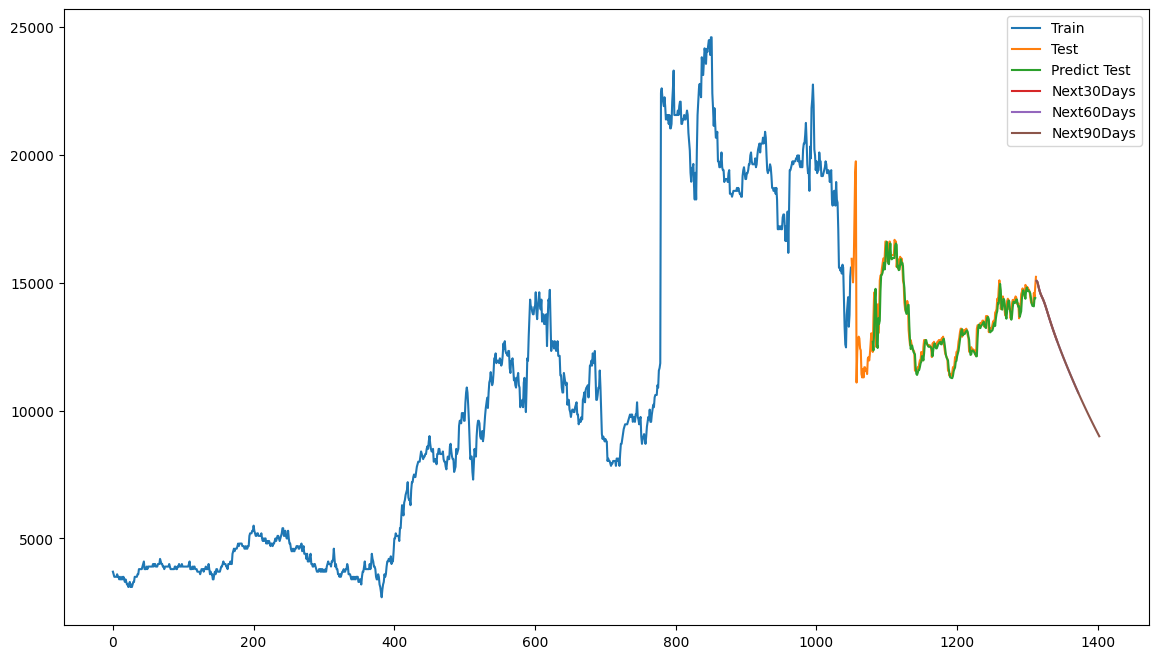

In [15]:
# 13. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predict Test')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()

# DHT Historical Data

In [16]:
# 2. Read data
data = pd.read_csv('DHT Historical Data.csv')

# Preprocessing data
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

data["Vol."] = data["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

data["Change %"] = data["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str):
    return float(str.replace(',', ''))

data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

df1 = data.reset_index()['Price']

In [17]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,40400.0,39300.0,41000.0,38900.0,154530,0.0280
1,05/30/2024,39300.0,38800.0,39800.0,38500.0,76570,-0.0051
2,05/29/2024,39500.0,39900.0,39900.0,38300.0,107350,0.0051
3,05/28/2024,39300.0,38600.0,39500.0,38200.0,61630,0.0181
4,05/27/2024,38600.0,35200.0,39900.0,35200.0,133260,0.0604
...,...,...,...,...,...,...,...
1307,03/07/2019,11589.7,11842.2,11842.2,11224.9,240150,0.0024
1308,03/06/2019,11561.6,11309.1,11589.7,11309.1,292910,0.0198
1309,03/05/2019,11337.1,11224.9,11365.2,10888.1,308000,0.0100
1310,03/04/2019,11224.9,11056.5,11477.4,11056.5,296000,0.0336


In [18]:
df1

0       40400.0
1       39300.0
2       39500.0
3       39300.0
4       38600.0
         ...   
1307    11589.7
1308    11561.6
1309    11337.1
1310    11224.9
1311    10860.1
Name: Price, Length: 1312, dtype: float64

In [19]:
# 3. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [20]:
# 4. Split train, test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [21]:
# 5. Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [22]:
# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
# 7. Define LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# 8. Fit the model with train data

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0324 - val_loss: 0.0027
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_loss: 9.6242e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011 - val_loss: 8.6102e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.4893e-04 - val_loss: 9.5419e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1984e-04 - val_loss: 9.6405e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.4355e-04 - val_loss: 8.5665e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.7778e-04 - val_loss: 6.5509e-04
Epoch 12/100

In [25]:
# 9. Predict test data
y_pred = model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [26]:
# 10. Valuation
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape, '%')
print('MSLE:', test_score_msle)

RMSE: 550.755608264896
MAPE: 2.95432722419578 %
MSLE: 0.0017079357525584455


In [27]:
# 11. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [28]:
# 12. Predict next 30 days, 60 days, 90 days

lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))

lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))

lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

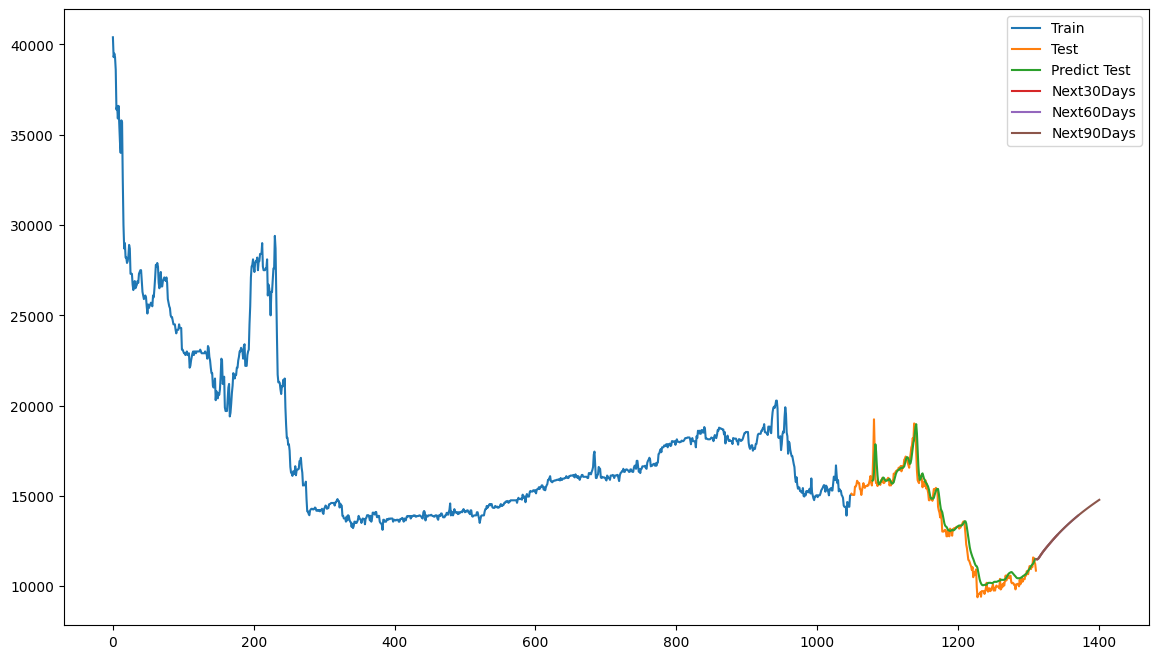

In [29]:
# 13. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predict Test')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()

# DP3 Historical Data

In [36]:
# Read data
data = pd.read_csv('DP3 Historical Data.csv')

# Preprocessing data
def convert_volume_to_number(volume):
    if isinstance(volume, str):
        if volume[-1] == 'K':
            return int(float(volume[:-1]) * 1000)
        elif volume[-1] == 'M':
            return int(float(volume[:-1]) * 1000000)
        elif volume[-1] == 'B':
            return int(float(volume[:-1]) * 1000000000)
        else:
            return int(volume)
    else:
        return volume

data["Vol."] = data["Vol."].apply(convert_volume_to_number)

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

data["Change %"] = data["Change %"].apply(convert_change_to_number)

def convert_str_to_number(str_value):
    return float(str_value.replace(',', ''))

data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

df1 = data.reset_index()['Price']

In [37]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,61600.0,61500.0,61700.0,61500.0,10510.0,0.0016
1,05/30/2024,61500.0,61000.0,61500.0,60700.0,5110.0,0.0082
2,05/29/2024,61000.0,62000.0,62000.0,61000.0,7300.0,0.0000
3,05/28/2024,61000.0,61000.0,61800.0,60900.0,7900.0,0.0016
4,05/27/2024,60900.0,61700.0,61700.0,60900.0,12670.0,-0.0016
...,...,...,...,...,...,...,...
1132,03/07/2019,76300.0,75000.0,76900.0,74700.0,11570.0,0.0214
1133,03/06/2019,74700.0,74100.0,75000.0,74000.0,3810.0,0.0040
1134,03/05/2019,74400.0,75000.0,75000.0,74000.0,7330.0,-0.0067
1135,03/04/2019,74900.0,73800.0,75200.0,73800.0,8340.0,0.0149


In [38]:
df1

0       61600.0
1       61500.0
2       61000.0
3       61000.0
4       60900.0
         ...   
1132    76300.0
1133    74700.0
1134    74400.0
1135    74900.0
1136    73800.0
Name: Price, Length: 1137, dtype: float64

In [39]:
# 3. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [40]:
# 4. Split train, test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [41]:
# 5. Create dataset function
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [42]:
# 6. Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [43]:
# 7. Define LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# 8. Fit the model with train data

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1093 - val_loss: 0.0028
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0204 - val_loss: 0.0042
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0066 - val_loss: 6.4186e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0061 - val_loss: 6.5835e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0046 - val_loss: 6.2507e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043 - val_loss: 5.3635e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0055 - val_loss: 6.6976e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - val_loss: 5.9071e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - val_loss: 4.8497e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033 - val_loss: 3.9493e-04
Epoch 12/100
14/14 ━

In [45]:
# 9. Predict test data
y_pred = model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [46]:
# 10. Valuation
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE:', test_score_rmse)
print('MAPE:', test_score_mape, '%')
print('MSLE:', test_score_msle)

RMSE: 1495.6762998253116
MAPE: 1.521155199901217 %
MSLE: 0.00047198207602289563


In [47]:
# 11. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [48]:
# 12. Predict next 30 days, 60 days, 90 days

lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))

lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))

lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

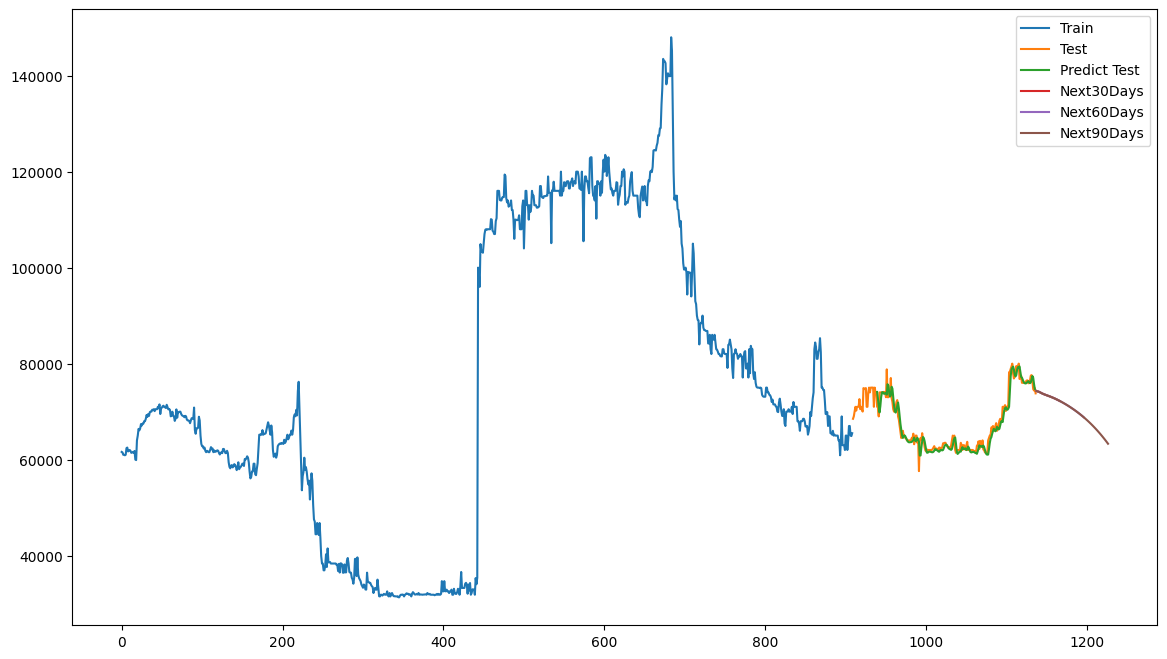

In [49]:
# 13. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predict Test')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()